In [3]:
import xarray as xr
import requests
import netCDF4
import boto3
import numpy as np
import pandas as pd
import seaborn as sns
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt

In [28]:
import sagemaker
import awswrangler as wr
import json
import time
from sagemaker.serializers import IdentitySerializer
from sagemaker import image_uris
import logging
import plotly.express as px

# Load Data

In [45]:
G16 = pd.read_csv("../workspace/bolide_detections_G16.csv")
G17 = pd.read_csv("../workspace/bolide_detections_G17.csv")
vetted = pd.read_csv("../workspace/vetted_data.csv")

In [43]:
print('G16 shape: ', G16.shape)
print()
print('G17 shape: ', G17.shape)
print()
print('Vetted Data shape: ', vetted.shape)
print()


G16 shape:  (69952, 6)

G17 shape:  (64808, 6)

Vetted Data shape:  (4079, 46)



In [31]:
G16.head()


,# detection_ID,detection_confidence,figure_filename,Data_filenames_list,event_or_group_IDs_recorded,ID:fileIndexForThisID
0,1620201601809043001,0.288,OR_GLM-L2-LCFA_G16_s20201601809000_e2020160180...,['OR_GLM-L2-LCFA_G16_s20201601809000_e20201601...,event_id,"['1129372724:0', '1129372725:0', '1129372726:0..."
1,1620201602009479001,0.244,OR_GLM-L2-LCFA_G16_s20201602009400_e2020160201...,['OR_GLM-L2-LCFA_G16_s20201602009400_e20201602...,event_id,"['1130289265:0', '1130289267:0', '1130289268:0..."
2,1620201601657529001,0.206,OR_GLM-L2-LCFA_G16_s20201601657400_e2020160165...,['OR_GLM-L2-LCFA_G16_s20201601657400_e20201601...,event_id,"['1129123753:0', '1129123755:0', '1129123756:0..."
3,1620201601652595001,0.180,OR_GLM-L2-LCFA_G16_s20201601652400_e2020160165...,['OR_GLM-L2-LCFA_G16_s20201601652400_e20201601...,event_id,"['1129089781:0', '1129089784:0', '1129089795:0..."
4,1620201601652598001,0.146,OR_GLM-L2-LCFA_G16_s20201601653000_e2020160165...,['OR_GLM-L2-LCFA_G16_s20201601653000_e20201601...,event_id,"['1129089683:0', '1129089684:0', '1129089707:0..."


In [8]:
G17.head()

,# detection_ID,detection_confidence,figure_filename,Data_filenames_list,event_or_group_IDs_recorded,ID:fileIndexForThisID
0,1720203241859456001,0.997805,OR_GLM-L2-LCFA_G17_s20203241859400_e2020324190...,['OR_GLM-L2-LCFA_G17_s20203241859400_e20203241...,event_id,"['17645172:0', '17645173:0', '17645174:0', '17..."
1,1720203241238212001,0.997805,OR_GLM-L2-LCFA_G17_s20203241238200_e2020324123...,['OR_GLM-L2-LCFA_G17_s20203241238200_e20203241...,event_id,"['17149369:0', '17149370:0', '17149371:0', '17..."
2,1720203241547094001,0.995609,OR_GLM-L2-LCFA_G17_s20203241547000_e2020324154...,['OR_GLM-L2-LCFA_G17_s20203241547000_e20203241...,event_id,"['17459447:0', '17459448:0', '17459449:0', '17..."
3,1720203241513553001,0.992316,OR_GLM-L2-LCFA_G17_s20203241513400_e2020324151...,['OR_GLM-L2-LCFA_G17_s20203241513400_e20203241...,event_id,"['17416798:0', '17416799:0', '17416800:0', '17..."
4,1720203241650215001,0.975834,OR_GLM-L2-LCFA_G17_s20203241650200_e2020324165...,['OR_GLM-L2-LCFA_G17_s20203241650200_e20203241...,event_id,"['17525977:0', '17525978:0', '17525979:0', '17..."


In [46]:
vetted['datetime'] = pd.to_datetime(vetted['datetime'])
vetted['latitude'] = pd.to_numeric(vetted['latitude'])
vetted['longitude'] = pd.to_numeric(vetted['longitude'])

vetted.head()

,datetime,longitude,latitude,source,detectedBy,confidenceRating,lightcurveStructure,energy_g16,energy_g17,brightness_g16,...,platform,reason,rejectedBy,rejectedDate,phase,moon_fullness,solarhour,sun_alt_obs,sun_alt_app,date_retrieved
0,2022-08-26 21:22:33,-111.2,-17.2,csv,GLM-16,low,minimal,2.584874e-15,NaN,4.784610e-15,...,GLM-16,NaN,NaN,NaN,0.984643,0.030713,13.933885,11.844155,11.770731,2022-09-15 09:08:15.662641
1,2022-08-26 13:31:35,-171.8,24.3,csv,GLM-17,low,minimal,NaN,2.184922e-15,NaN,...,GLM-17,NaN,NaN,NaN,0.973594,0.052813,2.042729,-14.965597,-14.965597,2022-09-15 09:08:15.662641
2,2022-08-26 03:07:24,-62.7,-29.9,csv,GLM-16,low,very good,2.284910e-15,NaN,9.484046e-15,...,GLM-16,NaN,NaN,NaN,0.958949,0.082102,22.911102,8.679489,8.580682,2022-09-15 09:08:15.662641
3,2022-08-25 22:28:57,-94.5,-27.6,csv,"GLM-16,GLM-17",medium,good,2.484886e-15,3.984706e-15,5.184562e-15,...,"GLM-16,GLM-17",NaN,NaN,NaN,0.952416,0.095168,16.149466,29.608102,29.580207,2022-09-15 09:08:15.662641
4,2022-08-25 11:58:44,-100.0,3.2,csv,"GLM-16,GLM-17",medium,good,1.285030e-15,1.984946e-15,3.684742e-15,...,"GLM-16,GLM-17",NaN,NaN,NaN,0.937630,0.124740,5.276858,-59.771839,-59.771839,2022-09-15 09:08:15.662641


# EDA

## Table Descriptions

In [10]:
G16.describe().detection_confidence

count    69952.000000
mean         0.076655
std          0.178533
min          0.010000
25%          0.012000
50%          0.020000
75%          0.046000
max          1.000000
Name: detection_confidence, dtype: float64

In [11]:
G17.describe().detection_confidence

count    64808.000000
mean         0.085018
std          0.186841
min          0.010977
25%          0.015368
50%          0.025247
75%          0.055982
max          1.000000
Name: detection_confidence, dtype: float64

In [12]:
vetted.describe()

,longitude,latitude,energy_g16,energy_g17,brightness_g16,brightness_g17,duration,latitudeDelta,longitudeDelta,beginningAltitude,__v,phase,moon_fullness,solarhour,sun_alt_obs,sun_alt_app
count,4079.000000,4079.000000,2.649000e+03,2.726000e+03,2.649000e+03,2.726000e+03,4079.000000,4079.000000,4079.000000,461.000000,4079.000000,4079.000000,4079.000000,4079.000000,4079.000000,4079.000000
mean,-92.370287,3.631370,4.546949e-15,4.199051e-15,3.466024e-14,3.115183e-14,19.883866,1.016671,1.305222,80.457701,0.129934,0.480955,0.483535,7.298087,-0.414660,-0.498352
std,68.760892,26.003672,1.576817e-14,1.246061e-14,1.403520e-13,1.594464e-13,2.016840,0.129951,0.486956,15.652783,0.517268,0.294698,0.286422,4.918479,34.977158,34.969224
min,-179.800000,-55.400000,8.850780e-16,-1.525970e-15,1.285030e-15,-1.525970e-15,0.300000,1.000000,1.000000,24.000000,0.000000,0.000354,0.000003,0.008367,-85.895387,-85.895387
25%,-136.850000,-16.500000,1.884958e-15,1.684982e-15,5.384538e-15,4.909595e-15,20.000000,1.000000,1.000000,78.000000,0.000000,0.212137,0.227883,4.135603,-24.589304,-24.589304
50%,-103.000000,4.500000,2.684862e-15,2.384898e-15,1.018396e-14,9.384058e-15,20.000000,1.000000,1.000000,84.000000,0.000000,0.476411,0.473178,6.360137,0.422999,-0.055619
75%,-63.000000,24.850000,4.577910e-15,4.184682e-15,2.238250e-14,2.088268e-14,20.000000,1.000000,2.000000,90.000000,0.000000,0.748546,0.725450,8.863028,23.955981,23.920304
max,179.900000,55.500000,7.141540e-13,5.874984e-13,3.921743e-12,5.395830e-12,100.000000,3.000000,4.000000,109.000000,9.000000,0.999998,0.999688,23.993219,88.967701,88.967415


## G16

<AxesSubplot:xlabel='detection_confidence'>

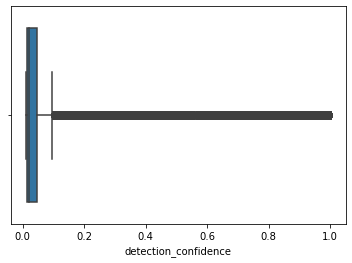

In [14]:
sns.boxplot(x=G16["detection_confidence"])

/tmp/ipykernel_104/1771338610.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


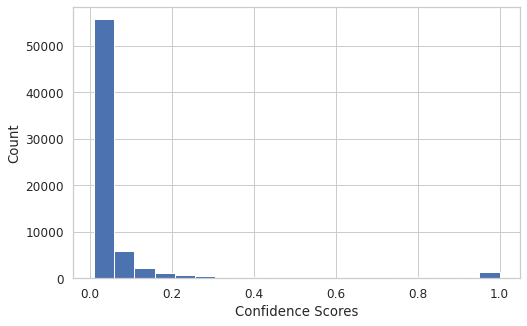

In [15]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    G16['detection_confidence'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Confidence Scores', ylabel='Count');

## G17

<AxesSubplot:xlabel='detection_confidence'>

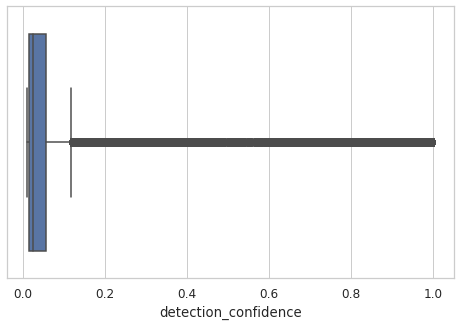

In [16]:
sns.boxplot(x=G17["detection_confidence"])

/tmp/ipykernel_104/750956744.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


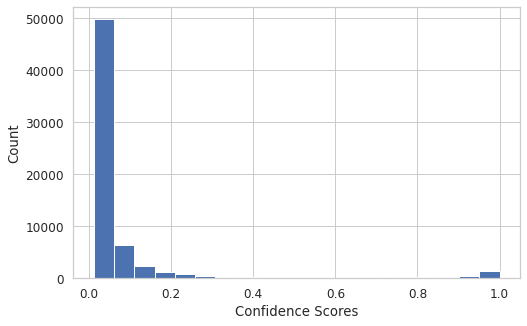

In [17]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    G17['detection_confidence'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Confidence Scores', ylabel='Count');

## Vetted

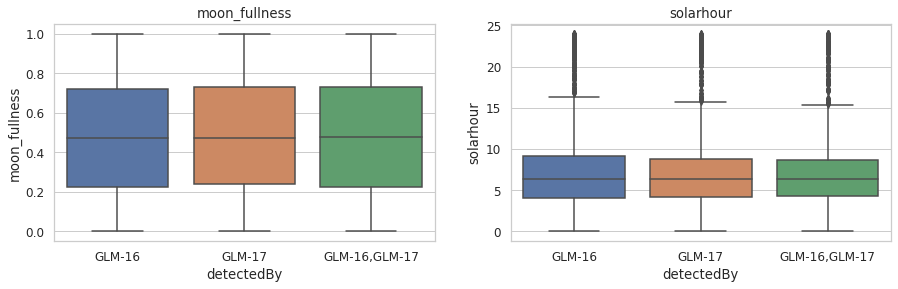

In [48]:
# columns to plot (2 columns plotted per row)
column_pairs_to_plot = [['moon_fullness','solarhour']]

# plot each boxplot
for column_pair in column_pairs_to_plot:
    
    fig, axs = plt.subplots(ncols = 2, figsize=(15, 4))
    
    column_1 = column_pair[0]
    column_2 = column_pair[1]
    
    sns.boxplot(x='detectedBy', y=column_1, data=vetted, ax = axs[0])
    axs[0].set_title(column_1)
    
    sns.boxplot(x='detectedBy', y=column_2, data=vetted, ax = axs[1])
    axs[1].set_title(column_2)
    plt.show()